In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import yfinance as yf

In [3]:
# Download the stock data
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
# Using only the 'Close' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

In [5]:
# Splitting the data into training and testing
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [6]:
# Function to create dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [7]:
# Create train and test datasets
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# Reshaping for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [10]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [12]:
# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
87/87 [==============================] - 18s 110ms/step - loss: 0.0026 - val_loss: 0.0055
Epoch 2/100
87/87 [==============================] - 7s 83ms/step - loss: 4.8842e-04 - val_loss: 0.0013
Epoch 3/100
87/87 [==============================] - 7s 83ms/step - loss: 4.5509e-04 - val_loss: 0.0014
Epoch 4/100
87/87 [==============================] - 7s 85ms/step - loss: 4.2281e-04 - val_loss: 9.5371e-04
Epoch 5/100
87/87 [==============================] - 7s 84ms/step - loss: 3.8043e-04 - val_loss: 0.0014
Epoch 6/100
87/87 [==============================] - 7s 84ms/step - loss: 3.7394e-04 - val_loss: 0.0056
Epoch 7/100
87/87 [==============================] - 7s 82ms/step - loss: 3.4822e-04 - val_loss: 0.0012
Epoch 8/100
87/87 [==============================] - 7s 81ms/step - loss: 2.7932e-04 - val_loss: 9.3453e-04
Epoch 9/100
87/87 [==============================] - 7s 76ms/step - loss: 2.6794e-04 - val_loss: 9.7946e-04
Epoch 10/100
87/87 [==============================] - 

In [13]:
# Save the model
model.save('lstm_model.h5')

In [14]:
# Predict and inverse transform
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

21/21 [==============================] - 2s 28ms/step


In [15]:
# Inverse transform y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 7.180339881251872


In [17]:
# Plotting the results
train = data[:train_size]
valid = data[train_size:train_size + len(predictions)].copy()
valid['Close'] = predictions.flatten()

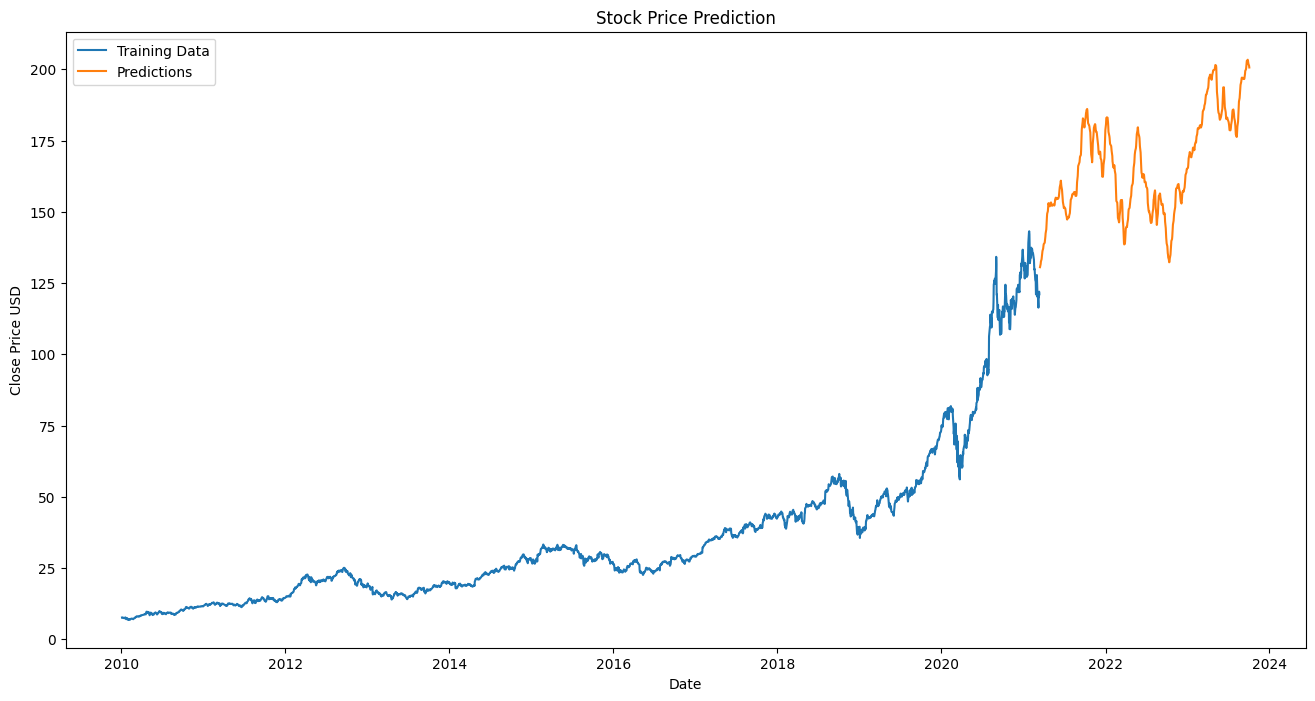

In [18]:
plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Predictions')
plt.legend()
plt.show()

In [19]:
# Accuracy: 1 - Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
accuracy = 100 - mape
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 96.14%


In [20]:
# Mean Absolute Error
mae = np.mean(np.abs(y_test - predictions))
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 6.10


In [21]:
# R-squared
ss_total = np.sum((y_test - np.mean(y_test))**2)
ss_residual = np.sum((y_test - predictions)**2)
r_squared = 1 - (ss_residual / ss_total)
print(f'R-squared: {r_squared:.2f}')

R-squared: 0.83
